In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
print(os.listdir("../input"))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session



['graph1', 'online-news-popularity-dataset']


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/graph1/graphviz.png
/kaggle/input/online-news-popularity-dataset/OnlineNewsPopularityReduced.csv


# 1. Decision Tree

Dowloaded data. Target variable is shares, issue is regression

In [2]:
df = pd.read_csv("../input/online-news-popularity-dataset/OnlineNewsPopularityReduced.csv")
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2014/09/28/jobs-tech-workers/,101,12,332,0.528481,1.0,0.645833,6,3,1,...,0.100000,0.7,-0.145833,-0.166667,-0.125000,0.718182,0.137121,0.218182,0.137121,8600
1,http://mashable.com/2014/09/28/obama-says-u-s-...,101,10,393,0.518817,1.0,0.596899,14,1,1,...,0.250000,0.8,-0.312500,-0.500000,-0.250000,0.500000,0.000000,0.000000,0.000000,23700
2,http://mashable.com/2014/09/28/once-upon-a-tim...,101,13,1643,0.388854,1.0,0.546967,29,4,7,...,0.033333,0.8,-0.227778,-0.800000,-0.050000,0.000000,0.000000,0.500000,0.000000,8400
3,http://mashable.com/2014/09/28/the-simpsons-de...,101,9,272,0.488889,1.0,0.512690,2,2,11,...,0.100000,1.0,-0.416667,-1.000000,-0.166667,0.000000,0.000000,0.500000,0.000000,4800
4,http://mashable.com/2014/09/28/viola-davis-les...,101,12,0,0.000000,0.0,0.000000,0,0,0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.541071,0.067560,0.041071,0.067560,3100


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4954 entries, 0 to 4953
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   url                            4954 non-null   object 
 1   timedelta                      4954 non-null   int64  
 2   n_tokens_title                 4954 non-null   int64  
 3   n_tokens_content               4954 non-null   int64  
 4   n_unique_tokens                4954 non-null   float64
 5   n_non_stop_words               4954 non-null   float64
 6   n_non_stop_unique_tokens       4954 non-null   float64
 7   num_hrefs                      4954 non-null   int64  
 8   num_self_hrefs                 4954 non-null   int64  
 9   num_imgs                       4954 non-null   int64  
 10  num_videos                     4954 non-null   int64  
 11  average_token_length           4954 non-null   float64
 12  num_keywords                   4954 non-null   i

This looks like exponential distribution.

(0.0, 15000.0)

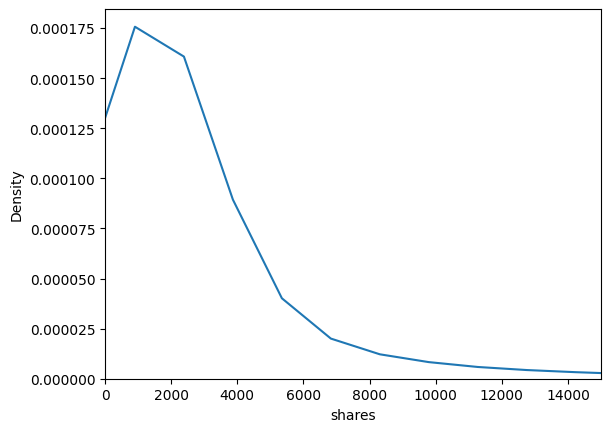

In [4]:
sns.kdeplot(df['shares'])
plt.xlim(0, 15000)

## Preprocessing

Lets drop columns `url`, because variable unique for all data set.  

In [5]:
df.drop(columns=['url'], axis=1, inplace=True)

Let also delete `kw_min_min` `kw_max_max` `n_non_stop_words` collumns, because all values same.

In [6]:
df['kw_max_max'].value_counts()

kw_max_max
843300    4951
663600       2
233400       1
Name: count, dtype: int64

In [7]:
df['kw_min_min'].value_counts()

kw_min_min
-1    4954
Name: count, dtype: int64

In [8]:
df['n_non_stop_words'].value_counts()

n_non_stop_words
1.0    1020
1.0     792
1.0     599
1.0     488
0.0     488
1.0     469
1.0     353
1.0     204
1.0     155
1.0     106
1.0      75
1.0      63
1.0      44
1.0      24
1.0      23
1.0      13
1.0       8
1.0       8
1.0       4
1.0       3
1.0       3
1.0       2
1.0       2
1.0       2
1.0       2
1.0       2
1.0       1
1.0       1
Name: count, dtype: int64

In [9]:
garbage = ['kw_max_max', 'kw_min_min', 'n_non_stop_words']
df.drop(columns=garbage, axis=1, inplace=True)

Lets delete anomaly articles that have shares>=15000 and <400 and log our target variable to make distribution more familiar to normal.

In [10]:
df['shares'].value_counts()

shares
1100     316
1200     279
1300     225
1400     224
1500     165
        ... 
26900      1
569        1
19100      1
477        1
470        1
Name: count, Length: 781, dtype: int64

In [11]:
df = df[df['shares'] <= 15000]
df = df[df['shares'] > 200]

<Axes: xlabel='shares', ylabel='Density'>

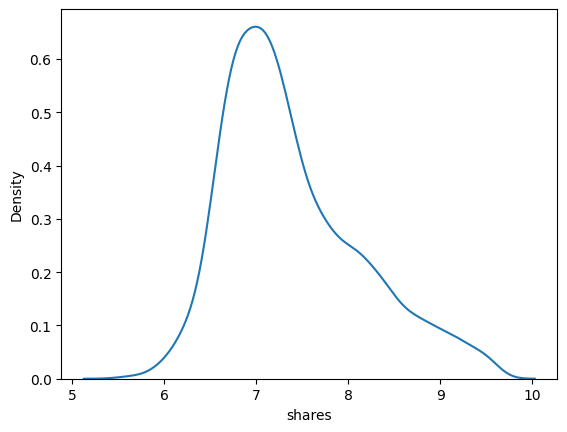

In [12]:
y_regretion = np.log(df['shares'])
sns.kdeplot(y_regretion)

Like previous model, lets also see classification issues.

In [13]:
df['is_popular'] = (df['shares'] > 1500).astype(int)
df.drop(columns=['shares'], axis=1, inplace=True)
df['is_popular'].value_counts()

is_popular
0    2741
1    2041
Name: count, dtype: int64

Because of we have Decision Tree and Random Forest, we dont need to scale our data

## Split Data

Now lets split data

In [14]:
from sklearn.model_selection import train_test_split
X = df.drop('is_popular', axis=1)
y_classification = df['is_popular']
X_train, X_valid, y_train_cl, y_valid_cl = train_test_split(X, y_classification, test_size=0.25, random_state=4)
X_train, X_valid, y_train_reg, y_valid_reg = train_test_split(X, y_regretion, test_size=0.25, random_state=4)

## Classifier and Regressor

In [15]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [16]:
tree_reg = DecisionTreeRegressor(random_state=20)
tree_class = DecisionTreeClassifier(random_state=20)

tree_reg.fit(X_train, y_train_reg)
tree_class.fit(X_train, y_train_cl)

y_pred_reg = tree_reg.predict(X_valid)
y_pred_cl = tree_class.predict(X_valid)

print("Mean score for Regresscor:", mean_squared_error(np.exp(y_valid_reg), np.exp((y_pred_reg))))
print("R2_Score for Regresscor:", r2_score(y_valid_reg, y_pred_reg))
print("Accuracy score for Classifier:", accuracy_score(y_valid_cl, y_pred_cl))

Mean score for Regresscor: 8768403.7625418
R2_Score for Regresscor: -0.5251443629297465
Accuracy score for Classifier: 0.6086956521739131


Lets see hyperparameter `max_depth` our trees.

In [17]:
print(tree_reg.tree_.max_depth)
print(tree_class.tree_.max_depth)

37
23


For the first time: classifier have less depth than regressor and have good result for prediction.

# 2. Hyperparameters for tree

## Cross-validation

We have 4 hyperparameters:
1. `max_depth` is depth our tree,
2. `min_samples_split` is minimum objects we have in leaf to split,
3. `min_samples_leaf` is minimum objects we have in leaf,
4. `max_features` is max features that we have in tree. 

In [18]:
hyperparameters = {
    'max_depth': np.arange(1, 11, 2), 
    'min_samples_split': np.arange(2, 11, 2), 
    'min_samples_leaf': np.arange(2, 11, 2),
    'max_features': np.arange(2, 21, 2)
}

In [19]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [20]:
kf = KFold(shuffle=True, random_state=32)
cross = kf.split(X)

Find best hyperparameters for our models using Grid Search.

In [21]:
cross = kf.split(X)
tree_grid_reg = GridSearchCV(tree_reg, hyperparameters, scoring='neg_mean_squared_error', cv=cross)

In [22]:
cross = kf.split(X)
tree_grid_cl = GridSearchCV(tree_class, hyperparameters, scoring='accuracy', cv=cross)

In [23]:
tree_grid_cl.fit(X, y_classification)

GridSearchCV(cv=<generator object _BaseKFold.split at 0x7b956ccaccf0>,
             estimator=DecisionTreeClassifier(random_state=20),
             param_grid={'max_depth': array([1, 3, 5, 7, 9]),
                         'max_features': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]),
                         'min_samples_leaf': array([ 2,  4,  6,  8, 10]),
                         'min_samples_split': array([ 2,  4,  6,  8, 10])},
             scoring='accuracy')

In [24]:
tree_grid_reg.fit(X, y_regretion)

GridSearchCV(cv=<generator object _BaseKFold.split at 0x7b956ccacc10>,
             estimator=DecisionTreeRegressor(random_state=20),
             param_grid={'max_depth': array([1, 3, 5, 7, 9]),
                         'max_features': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]),
                         'min_samples_leaf': array([ 2,  4,  6,  8, 10]),
                         'min_samples_split': array([ 2,  4,  6,  8, 10])},
             scoring='neg_mean_squared_error')

Let see best params and score that we have.

In [25]:
print("Best params for classification:", tree_grid_cl.best_params_)
print("Best score for classification:", tree_grid_cl.best_score_)
print("Best params for regressor:", tree_grid_reg.best_params_)
print("Best neg mean score for regressor:", tree_grid_reg.best_score_)

Best params for classification: {'max_depth': 7, 'max_features': 10, 'min_samples_leaf': 2, 'min_samples_split': 8}
Best score for classification: 0.6629064414160359
Best params for regressor: {'max_depth': 5, 'max_features': 16, 'min_samples_leaf': 10, 'min_samples_split': 2}
Best neg mean score for regressor: -0.45573078625257146


Now lets test our model on valid data.

In [26]:
best_tree_cl = tree_grid_cl.best_estimator_
best_tree_reg = tree_grid_reg.best_estimator_
y_pred_cl = best_tree_cl.predict(X_valid)
y_pred_reg = best_tree_reg.predict(X_valid)

We can see result better than first time. But regression model have anyway bad result.

In [27]:
print("Mean score for Regresscor:", mean_squared_error(np.exp(y_valid_reg), np.exp((y_pred_reg))))
print("R2_Score for Regresscor:", r2_score(np.exp(y_valid_reg),np.exp(y_pred_reg)))
print("Accuracy score for Classifier:", accuracy_score(y_valid_cl, y_pred_cl))

Mean score for Regresscor: 4414994.514847938
R2_Score for Regresscor: 0.1368425392911744
Accuracy score for Classifier: 0.7140468227424749


## Graphics

Lets see how hyperparameters change our result.

In [28]:
from sklearn.model_selection import validation_curve

In [29]:
r2_scores_depth = validation_curve(tree_grid_reg.best_estimator_, X_train, y_train_reg, param_name="max_depth", param_range=np.arange(1, 21, 2), scoring='r2')[1]

In [30]:
r2_scores_split = validation_curve(tree_grid_reg.best_estimator_, X_train, y_train_reg, param_name="min_samples_split", param_range=np.arange(1, 21, 2), scoring='r2')[1]

In [31]:
r2_scores_leaf = validation_curve(tree_grid_reg.best_estimator_, X_train, y_train_reg, param_name="min_samples_leaf", param_range=np.arange(1, 21, 2), scoring='r2')[1]

In [32]:
r2_scores_feat = validation_curve(tree_grid_reg.best_estimator_, X_train, y_train_reg, param_name="max_features", param_range=np.arange(1, 21, 2), scoring='r2')[1]

In [33]:
acur_depth = validation_curve(tree_grid_cl.best_estimator_, X_train, y_train_cl, param_name="max_depth", param_range=np.arange(1, 21, 2), scoring='accuracy')[1]

In [34]:
acur_split = validation_curve(tree_grid_cl.best_estimator_, X_train, y_train_cl, param_name="min_samples_split", param_range=np.arange(1, 21, 2), scoring='accuracy')[1]

In [35]:
acur_leaf = validation_curve(tree_grid_cl.best_estimator_, X_train, y_train_cl, param_name="min_samples_leaf", param_range=np.arange(1, 21, 2), scoring='accuracy')[1]

In [36]:
acur_feat = validation_curve(tree_grid_cl.best_estimator_, X_train, y_train_cl, param_name="max_features", param_range=np.arange(1, 21, 2), scoring='accuracy')[1]

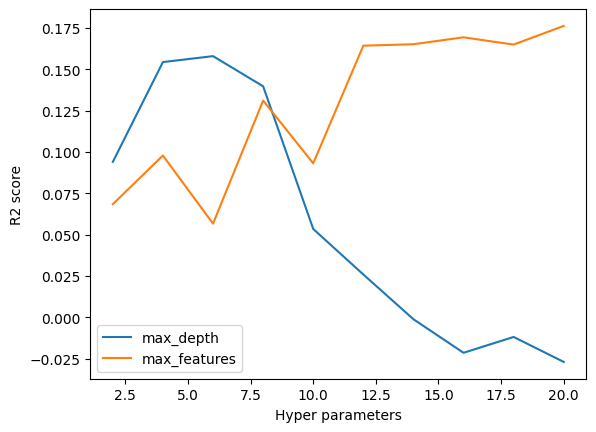

In [37]:
plt.plot(list(range(2, 21, 2)), np.mean(r2_scores_depth,  axis=1))
plt.plot(list(range(2, 21, 2)), np.mean(r2_scores_feat, axis=1))
plt.legend (('max_depth', 'max_features'))
plt.xlabel('Hyper parameters')
plt.ylabel('R2 score')
plt.show()

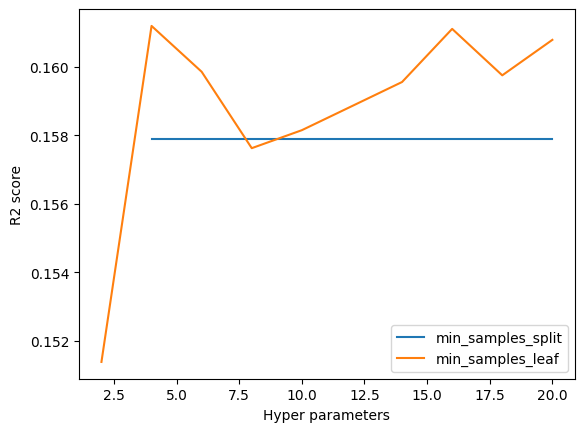

In [38]:
plt.plot(list(range(2, 21, 2)), np.mean(r2_scores_split,  axis=1))
plt.plot(list(range(2, 21, 2)), np.mean(r2_scores_leaf, axis=1))
plt.legend (('min_samples_split', 'min_samples_leaf', 'max_features'))
plt.xlabel('Hyper parameters')
plt.ylabel('R2 score')
plt.show()

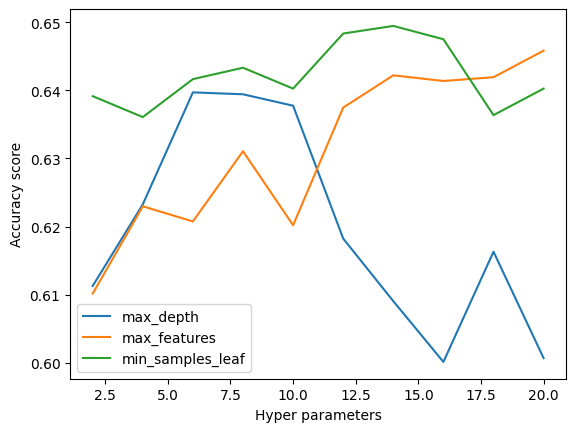

In [39]:
plt.plot(list(range(2, 21, 2)), np.mean(acur_depth,  axis=1))
plt.plot(list(range(2, 21, 2)), np.mean(acur_feat,  axis=1))
plt.plot(list(range(2, 21, 2)), np.mean(acur_leaf, axis=1))
plt.legend (('max_depth', 'max_features', 'min_samples_leaf'))
plt.xlabel('Hyper parameters')
plt.ylabel('Accuracy score')
plt.show()

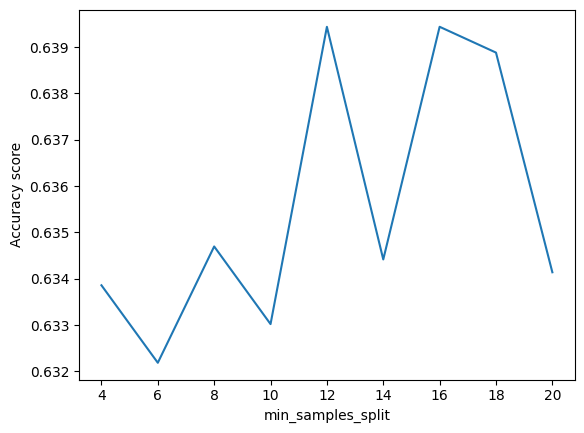

In [40]:
plt.plot(list(range(2, 21, 2)), np.mean(acur_split, axis=1))
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy score')
plt.show()

#### `max_depth` and `min_samples_split` have negative correlation with score at some value. `max_features` by contrast have positive correlation.

## Visualization of graph

In [41]:
from sklearn.tree import export_graphviz
export_graphviz(best_tree_cl, out_file='../tree.dot', feature_names=X.columns)
print(open('../tree.dot').read())

digraph Tree {
node [shape=box, fontname="helvetica"] ;
edge [fontname="helvetica"] ;
0 [label="timedelta <= 77.5\ngini = 0.489\nsamples = 4782\nvalue = [2741, 2041]"] ;
1 [label="kw_max_avg <= 4330.292\ngini = 0.475\nsamples = 4243\nvalue = [2593, 1650]"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="self_reference_max_shares <= 1750.0\ngini = 0.4\nsamples = 2156\nvalue = [1559, 597]"] ;
1 -> 2 ;
3 [label="LDA_00 <= 0.199\ngini = 0.308\nsamples = 969\nvalue = [785, 184]"] ;
2 -> 3 ;
4 [label="self_reference_min_shares <= 1050.0\ngini = 0.276\nsamples = 797\nvalue = [665, 132]"] ;
3 -> 4 ;
5 [label="LDA_04 <= 0.597\ngini = 0.246\nsamples = 592\nvalue = [507, 85]"] ;
4 -> 5 ;
6 [label="n_non_stop_unique_tokens <= 0.525\ngini = 0.225\nsamples = 543\nvalue = [473, 70]"] ;
5 -> 6 ;
7 [label="gini = 0.453\nsamples = 49\nvalue = [32, 17]"] ;
6 -> 7 ;
8 [label="gini = 0.192\nsamples = 494\nvalue = [441, 53]"] ;
6 -> 8 ;
9 [label="max_negative_polarity <= -0.038\ngi

![](https://dreampuf.github.io/GraphvizOnline/#digraph%20Tree%20%7B%0Anode%20%5Bshape%3Dbox%2C%20fontname%3D%22helvetica%22%5D%20%3B%0Aedge%20%5Bfontname%3D%22helvetica%22%5D%20%3B%0A0%20%5Blabel%3D%22kw_max_avg%20%3C%3D%204329.286%5Cngini%20%3D%200.49%5Cnsamples%20%3D%203586%5Cnvalue%20%3D%20%5B2048%2C%201538%5D%22%5D%20%3B%0A1%20%5Blabel%3D%22self_reference_avg_sharess%20%3C%3D%201196.25%5Cngini%20%3D%200.433%5Cnsamples%20%3D%201798%5Cnvalue%20%3D%20%5B1227%2C%20571%5D%22%5D%20%3B%0A0%20-%3E%201%20%5Blabeldistance%3D2.5%2C%20labelangle%3D45%2C%20headlabel%3D%22True%22%5D%20%3B%0A2%20%5Blabel%3D%22LDA_00%20%3C%3D%200.866%5Cngini%20%3D%200.329%5Cnsamples%20%3D%20603%5Cnvalue%20%3D%20%5B478%2C%20125%5D%22%5D%20%3B%0A1%20-%3E%202%20%3B%0A3%20%5Blabel%3D%22gini%20%3D%200.318%5Cnsamples%20%3D%20591%5Cnvalue%20%3D%20%5B474%2C%20117%5D%22%5D%20%3B%0A2%20-%3E%203%20%3B%0A4%20%5Blabel%3D%22gini%20%3D%200.444%5Cnsamples%20%3D%2012%5Cnvalue%20%3D%20%5B4%2C%208%5D%22%5D%20%3B%0A2%20-%3E%204%20%3B%0A5%20%5Blabel%3D%22LDA_04%20%3C%3D%200.426%5Cngini%20%3D%200.468%5Cnsamples%20%3D%201195%5Cnvalue%20%3D%20%5B749%2C%20446%5D%22%5D%20%3B%0A1%20-%3E%205%20%3B%0A6%20%5Blabel%3D%22gini%20%3D%200.432%5Cnsamples%20%3D%20861%5Cnvalue%20%3D%20%5B589%2C%20272%5D%22%5D%20%3B%0A5%20-%3E%206%20%3B%0A7%20%5Blabel%3D%22gini%20%3D%200.499%5Cnsamples%20%3D%20334%5Cnvalue%20%3D%20%5B160%2C%20174%5D%22%5D%20%3B%0A5%20-%3E%207%20%3B%0A8%20%5Blabel%3D%22timedelta%20%3C%3D%2086.5%5Cngini%20%3D%200.497%5Cnsamples%20%3D%201788%5Cnvalue%20%3D%20%5B821%2C%20967%5D%22%5D%20%3B%0A0%20-%3E%208%20%5Blabeldistance%3D2.5%2C%20labelangle%3D-45%2C%20headlabel%3D%22False%22%5D%20%3B%0A9%20%5Blabel%3D%22weekday_is_sunday%20%3C%3D%200.5%5Cngini%20%3D%200.499%5Cnsamples%20%3D%201699%5Cnvalue%20%3D%20%5B821%2C%20878%5D%22%5D%20%3B%0A8%20-%3E%209%20%3B%0A10%20%5Blabel%3D%22gini%20%3D%200.5%5Cnsamples%20%3D%201560%5Cnvalue%20%3D%20%5B787%2C%20773%5D%22%5D%20%3B%0A9%20-%3E%2010%20%3B%0A11%20%5Blabel%3D%22gini%20%3D%200.37%5Cnsamples%20%3D%20139%5Cnvalue%20%3D%20%5B34%2C%20105%5D%22%5D%20%3B%0A9%20-%3E%2011%20%3B%0A12%20%5Blabel%3D%22gini%20%3D%200.0%5Cnsamples%20%3D%2089%5Cnvalue%20%3D%20%5B0%2C%2089%5D%22%5D%20%3B%0A8%20-%3E%2012%20%3B%0A%7D)

## Importance

Lets see features that have the biggest importance for model on grid search - this is:
1. self_reference_avg_sharess
2. kw_max_avg
3. num_imgs
4. avg_positive_polarity

On first lab we have similar result, when we search correlation between shares and features.

In [42]:
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': np.round(best_tree_cl.feature_importances_, 3)}).sort_values('importance', ascending=False)
feature_importances[:15]

,feature,importance
22,kw_max_avg,0.209
0,timedelta,0.197
25,self_reference_max_shares,0.089
34,is_weekend,0.062
39,LDA_04,0.061
23,kw_avg_avg,0.036
4,n_non_stop_unique_tokens,0.025
21,kw_min_avg,0.023
20,kw_avg_max,0.021
24,self_reference_min_shares,0.019


# 3. Random Forest

Now lets try Random Forest model.

In [43]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [44]:
rg_reg = RandomForestRegressor(random_state=20)
rg_class = RandomForestClassifier(random_state=20)

rg_reg.fit(X_train, y_train_reg)
rg_class.fit(X_train, y_train_cl)

y_pred_reg = rg_reg.predict(X_valid)
y_pred_cl = rg_class.predict(X_valid)

print("Mean score for Regresscor:", mean_squared_error(np.exp(y_valid_reg), np.exp((y_pred_reg))))
print("R2_Score for Regresscor:", r2_score(y_valid_reg, y_pred_reg))
print("Accuracy score for Classifier:", accuracy_score(y_valid_cl, y_pred_cl))

Mean score for Regresscor: 4477008.064112339
R2_Score for Regresscor: 0.22304137483724606
Accuracy score for Classifier: 0.6923076923076923


Without cross validation we have better on Random Forest model result than on Decision tree model

## Cross Valdation

We have 5 hyperparameters:
1. `max_depth` is depth our tree,
2. `min_samples_split` is minimum objects we have in leaf to split,
3. `min_samples_leaf` is minimum objects we have in leaf,
4. `max_features` is max features that we have in tree. 
5. `n_estimators` is count of tree

In [45]:
hyperparameters = {
    'n_estimators' : np.arange(50, 400, 50),
    'max_depth': np.arange(1, 11, 2), 
    'min_samples_split': np.arange(2, 6, 2), 
    'min_samples_leaf': np.arange(2, 6, 2),
    'max_features': np.arange(10, 20, 2)
}

Because of I cant use GPU, I will use `RandomizedSearchCV`

In [46]:
from sklearn.model_selection import RandomizedSearchCV

In [47]:
cross = kf.split(X)
rf_grid_cl = RandomizedSearchCV(rg_class, hyperparameters, scoring='accuracy', cv=cross)
cross = kf.split(X)
rf_grid_reg = RandomizedSearchCV(rg_reg, hyperparameters, scoring='neg_mean_squared_error', cv=cross)

In [48]:
rf_grid_cl.fit(X, y_classification)

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7b956c71ace0>,
                   estimator=RandomForestClassifier(random_state=20),
                   param_distributions={'max_depth': array([1, 3, 5, 7, 9]),
                                        'max_features': array([10, 12, 14, 16, 18]),
                                        'min_samples_leaf': array([2, 4]),
                                        'min_samples_split': array([2, 4]),
                                        'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350])},
                   scoring='accuracy')

In [49]:
rf_grid_reg.fit(X, y_regretion)

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7b956c71ad50>,
                   estimator=RandomForestRegressor(random_state=20),
                   param_distributions={'max_depth': array([1, 3, 5, 7, 9]),
                                        'max_features': array([10, 12, 14, 16, 18]),
                                        'min_samples_leaf': array([2, 4]),
                                        'min_samples_split': array([2, 4]),
                                        'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350])},
                   scoring='neg_mean_squared_error')

Let see best params and score that we have.

In [50]:
print("Best params for classification:", rf_grid_cl.best_params_)
print("Best score for classification:", rf_grid_cl.best_score_)
print("Best params for regressor:", rf_grid_reg.best_params_)
print("Best neg mean score for regressor:", rf_grid_reg.best_score_)

Best params for classification: {'n_estimators': 50, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 18, 'max_depth': 9}
Best score for classification: 0.6852832902681408
Best params for regressor: {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 16, 'max_depth': 7}
Best neg mean score for regressor: -0.42802107394004574


Now lets test our model on valid data.

In [51]:
best_rf_cl = rf_grid_cl.best_estimator_
y_pred_cl = best_rf_cl.predict(X_valid)

In [52]:
best_rf_reg = rf_grid_reg.best_estimator_
y_pred_reg = best_rf_reg.predict(X_valid)

In [53]:
print("Mean score for Regresscor:", mean_squared_error(np.exp(y_valid_reg), np.exp((y_pred_reg))))
print("R2_Score for Regresscor:", r2_score(np.exp(y_valid_reg),np.exp(y_pred_reg)))
print("Accuracy score for Classifier:", accuracy_score(y_valid_cl, y_pred_cl))

Mean score for Regresscor: 4077992.7730146404
R2_Score for Regresscor: 0.2027283669534765
Accuracy score for Classifier: 0.8678929765886287


This is the best result that I have had by now

## Graphics

Lets see how hyperparameters change our result for classifier.

In [54]:
acur_n = validation_curve(rf_grid_cl.best_estimator_, X_train, y_train_cl, param_name="n_estimators", param_range=np.arange(50, 400, 50), scoring='accuracy')[1]
acur_depth = validation_curve(rf_grid_cl.best_estimator_, X_train, y_train_cl, param_name="max_depth", param_range=np.arange(1, 21, 2), scoring='accuracy')[1]
acur_split = validation_curve(rf_grid_cl.best_estimator_, X_train, y_train_cl, param_name="min_samples_split", param_range=np.arange(1, 21, 2), scoring='accuracy')[1]
acur_leaf = validation_curve(rf_grid_cl.best_estimator_, X_train, y_train_cl, param_name="min_samples_leaf", param_range=np.arange(1, 21, 2), scoring='accuracy')[1]
acur_feat = validation_curve(rf_grid_cl.best_estimator_, X_train, y_train_cl, param_name="max_features", param_range=np.arange(1, 21, 2), scoring='accuracy')[1]

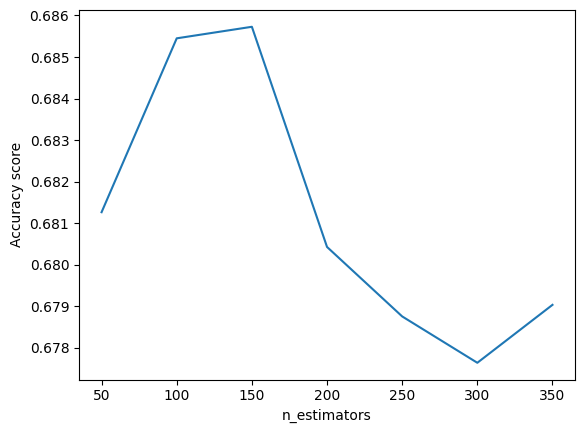

In [55]:
plt.plot(list(range(50, 400, 50)), np.mean(acur_n,  axis=1))
plt.xlabel('n_estimators')
plt.ylabel('Accuracy score')
plt.show()

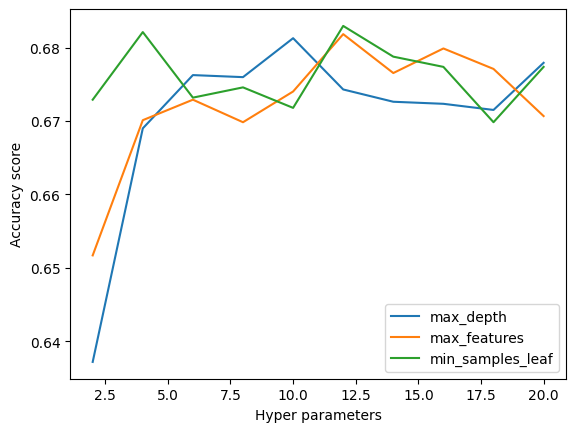

In [56]:
plt.plot(list(range(2, 21, 2)), np.mean(acur_depth,  axis=1))
plt.plot(list(range(2, 21, 2)), np.mean(acur_feat,  axis=1))
plt.plot(list(range(2, 21, 2)), np.mean(acur_leaf, axis=1))
plt.legend (('max_depth', 'max_features', 'min_samples_leaf'))
plt.xlabel('Hyper parameters')
plt.ylabel('Accuracy score')
plt.show()

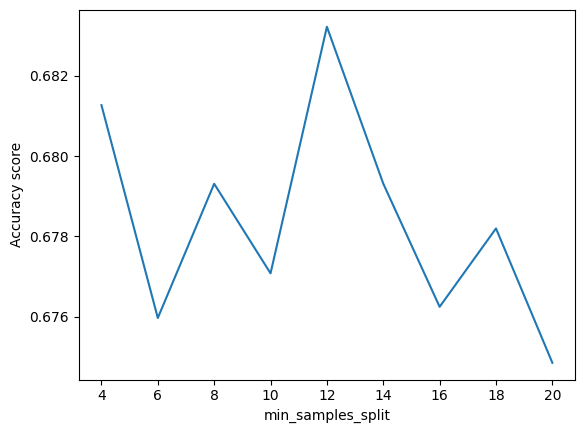

In [57]:
plt.plot(list(range(2, 21, 2)), np.mean(acur_split, axis=1))
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy score')
plt.show()

We can see that `max_depth`, `max_features`, `min_samples_leaf` at some value we have almost the same result

## Importance

Lets see features that have the biggest importance for model on grid search

<BarContainer object of 10 artists>

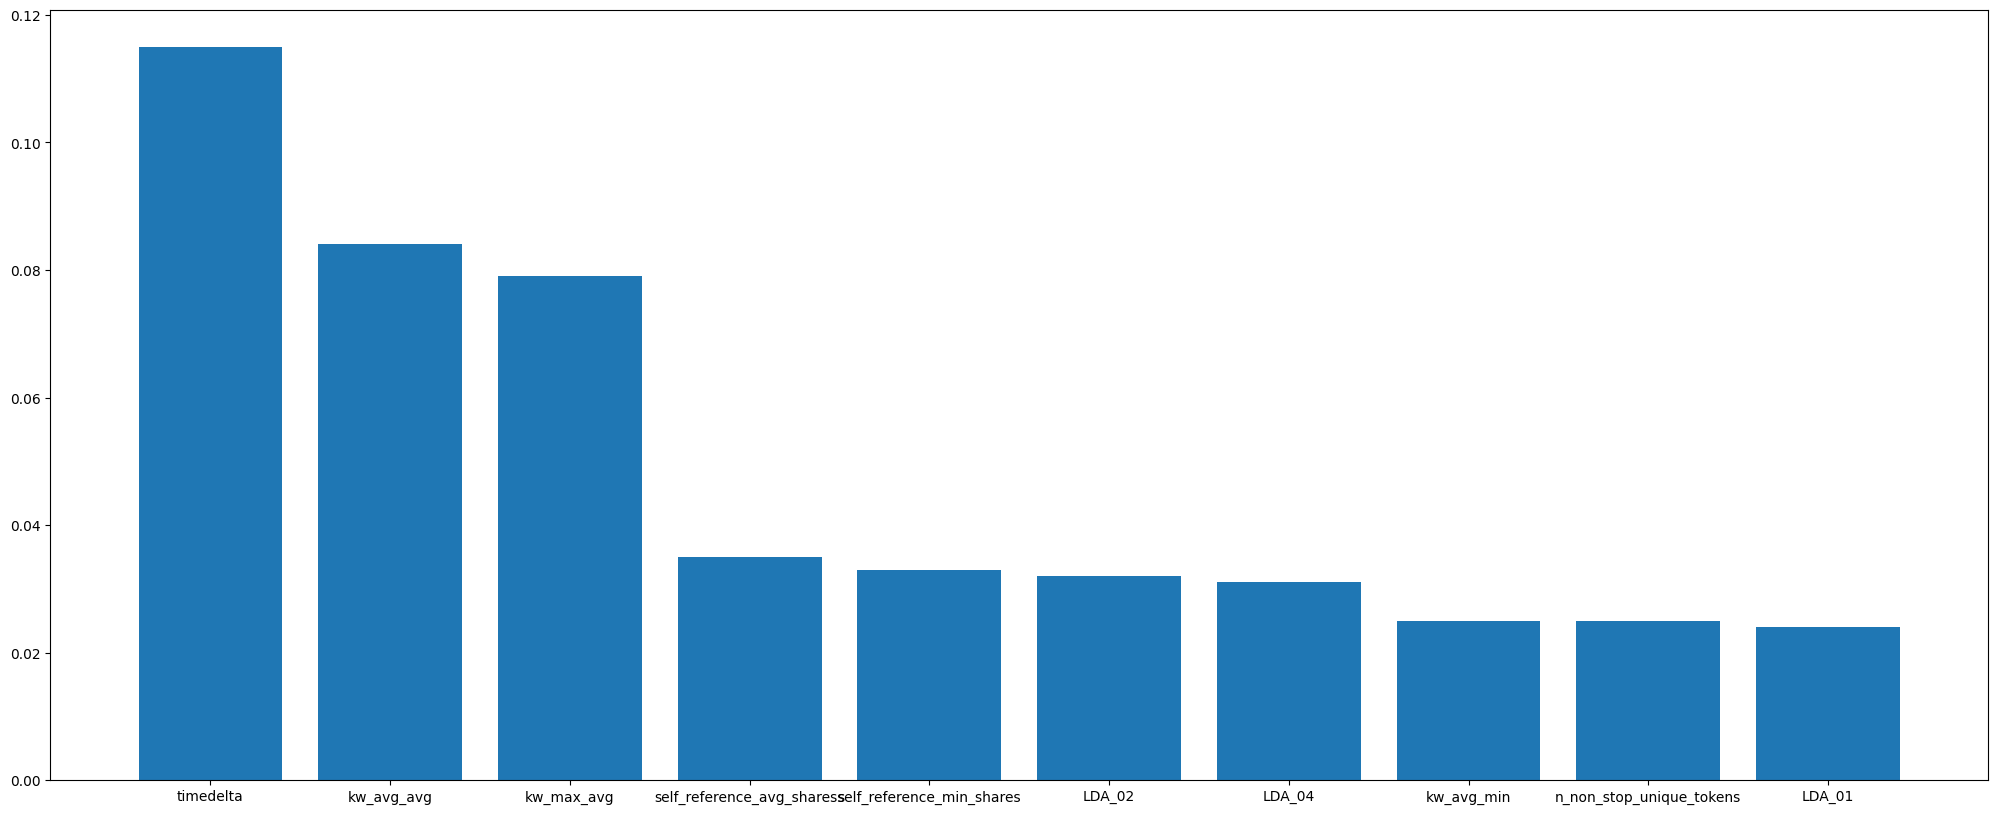

In [58]:
plt.figure(figsize=(25,10))
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': np.round(best_rf_cl.feature_importances_, 3)}).sort_values('importance', ascending=False)
plt.bar(feature_importances[:10].feature, feature_importances[:10].importance)

# Summary

Random Forest have better accuracy and r2 score than Decision Tree and spend more time to find better hyperparameters when searching on CPU. Unfortunaly, on this work I coundt use GPU. I can not compare with KNN model, because i have another preprocesing.